## **Меры качества кластеризации**

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import cluster, mixture
from sklearn import model_selection, preprocessing
from sklearn import metrics
from sklearn.decomposition import PCA, TruncatedSVD

import warnings
warnings.filterwarnings('ignore')

In [151]:
train = pd.read_csv('data/Physical Activity Data/train.txt', engine='python', header=None, sep=' ', skipinitialspace=True)
test = pd.read_csv('data/Physical Activity Data/test.txt', engine='python', header=None, sep=' ', skipinitialspace=True)
train_labels = pd.read_csv('data/Physical Activity Data/train_labels.txt', engine='python', header=None, sep=' ', names=['activity'], skipinitialspace=True)
test_labels = pd.read_csv('data/Physical Activity Data/test_labels.txt', engine='python', header=None, sep=' ', names=['activity'], skipinitialspace=True)

**Задание 4.1**

Так как изначально данные были представлены для решения задачи классификации, то они находятся в разных файлах (обучающая и тестовая выборки в соотношении 70/30). Соедините признаки так, чтобы сначала шла обучающая выборка, а затем — тестовая, и отдельно соедините значения целевых переменных (разумеется, в том же порядке).

Какая размерность получилась у набора данных с признаками?

In [172]:
X = pd.concat([train, test ], axis=0)
y = pd.concat([train_labels, test_labels], axis=0)

X.shape

(10299, 561)

**Задание 4.2**

Теперь найдите число различных активностей, то есть на сколько кластеров в идеале должны разделиться наблюдения.

In [138]:
y.nunique()

actvity    6
dtype: int64

**Задание 4.3**

Далее необходимо отмасштабировать признаки. Будем использовать для этого алгоритм StandardScaler. Примените его ко всем значениям признаков и впишите в качестве ответа значение первого признака для первого объекта, предварительно округлив его до двух знаков после точки-разделителя.

In [173]:
scaler = preprocessing.StandardScaler()
X_norm = scaler.fit_transform(X)

X_norm[0][0].round(2)

0.21

**Задание 4.4**

Пора переходить к кластеризации. Для начала определите оптимальное количество кластеров, используя внутренние меры кластеризации. Используйте все известные вам коэффициенты, реализуемые в библиотеке sklearn: коэффициент силуэта, индекс Калински — Харабаса и индекс Дэвиса — Болдина. В качестве алгоритма возьмите k-means++, в качестве значения параметра random_state — число 42.

Выведите оптимальное количество кластеров для каждой метрики, перебирая значения от 2 до 9 включительно. Также введите значение каждой метрики, округлённое до двух знаков после точки-разделителя.

In [140]:
met_list = []
for i in range(2, 10):
    km = cluster.KMeans(n_clusters=i, random_state=42).fit(X_norm)
    sil_s = metrics.silhouette_score(X_norm, km.labels_).round(2)
    ch_s = metrics.calinski_harabasz_score(X_norm, km.labels_).round(2)
    db_s = -metrics.davies_bouldin_score(X_norm, km.labels_).round(2)
    met_list.append((i, sil_s, ch_s, db_s))

df_met = pd.DataFrame(met_list, columns=['n_cluster', 'silhouette', 'calinski_harabasz', '-davies_bouldin'])




In [143]:
for j in df_met.columns[1:]:
    print(df_met.sort_values(j, ascending=False)[[j, 'n_cluster']].iloc[:1])

   silhouette  n_cluster
0        0.39          2
   calinski_harabasz  n_cluster
0            7880.81          2
   -davies_bouldin  n_cluster
0            -1.07          2


**Задание 4.5**

Теперь давайте оценим качество кластеризации с точки зрения внешних мер. Реализуйте кластеризацию с помощью классической версии алгоритма k-means. Пусть количество кластеров будет соответствовать количеству активностей. Задайте следующие значения параметров: random_state=42, init='random'.

В качестве ответов введите значения получившихся мер, предварительно округлив их до двух знаков после точки-разделителя.

In [162]:
km_4_5 = cluster.KMeans(n_clusters=6, random_state=42, init='random').fit(X_norm)
print('Homogeneity___{:.2f}'.format(metrics.homogeneity_score(y['activity'], km_4_5.labels_)))
print('Completeness__{:.2f}'.format(metrics.completeness_score(y["activity"], km_4_5.labels_)))
print('ARI___________{:.2f}'.format(metrics.adjusted_rand_score(y["activity"], km_4_5.labels_)))


Homogeneity___0.54
Completeness__0.58
ARI___________0.42


**Задание 4.6**

Выясните, к каким кластерам были преимущественно отнесены различные активности (т. е. в какой кластер попало большинство наблюдений с этой активностью). Нумерацию кластеров начинайте с 1.

In [177]:
y_cross = pd.crosstab(y.activity, km_4_5.labels_)
y_cross.index = ['ходьба', 'подъём', 
            'спуск', 'сидение', 'стояние', 'лежание']
y_cross.columns = list(range(1,7))

y_cross

,1,2,3,4,5,6
ходьба,0,0,903,78,741,0
подъём,0,0,1242,5,295,2
спуск,0,0,321,196,889,0
сидение,91,1238,1,0,0,447
стояние,0,1346,0,0,0,560
лежание,1556,54,5,0,0,329


**Задание 4.7**

Теперь попробуйте реализовать алгоритм k-means для двух кластеров (для того числа активностей, которое является оптимальным с точки зрения внутренних мер) и снова посмотреть, как алгоритм разобьёт активности по кластерам. Как и в предыдущем задании, нумерацию кластеров начинайте с 1.

In [180]:
km_4_7 = cluster.KMeans(n_clusters=2, random_state=42, init='random').fit(X_norm)
y_cross = pd.crosstab(y.activity, km_4_7.labels_)
y_cross.index = ['ходьба', 'подъём', 
            'спуск', 'сидение', 'стояние', 'лежание']
y_cross.columns = list(range(1,3))

y_cross

,1,2
ходьба,1722,0
подъём,1536,8
спуск,1406,0
сидение,3,1774
стояние,0,1906
лежание,12,1932


**Задание 4.8**

Вычислите значение полноты для разбиения на два кластера алгоритмом k-means. Ответ округлите до двух знаков после точки-разделителя.

In [181]:
metrics.completeness_score(y.activity, km_4_7.labels_).round(2)

0.98

**Задание 4.10**

Давайте сравним полученный результат с агломеративной иерархической кластеризацией. Реализуйте её также для двух кластеров и вычислите значение полноты.

In [182]:
ai_4_10 = cluster.AgglomerativeClustering(n_clusters=2).fit(X_norm)
metrics.completeness_score(y.activity, ai_4_10.labels_).round(2)

1.0

# **Снижение размерности**

In [183]:
country = pd.read_csv('data/Country-data.zip')
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


- country — название страны;
- child_mort — показатель смертности детей до 5 лет;
- exports — показатель экспорта на душу населения;
- health — показатель затрат на здравоохранение на душу населения;
- imports — показатель импорта на душу населения;
- Income — средний доход на душу населения;
- Inflation — годовой показатель инфляции;
- life_expec — средняя продолжительность жизни;
- total_fer — суммарный коэффициент рождаемости;
- gdpp — значение ВВП на душу населения.

**Задание 7.1**

Каково максимальное значение показателя средней продолжительности жизни среди представленных стран? Ответ округлите до одного знака после точки-разделителя.

In [184]:
country.life_expec.max()

82.8

**Задание 7.2**

Чтобы получить более качественные результаты, необходимо стандартизировать данные. Используйте для этого StandardScaler. Примените его ко всем значениям признаков и впишите в качестве ответа значение первого признака для первого объекта (таким образом можно будет проверить, что вы всё сделали корректно). Ответ округлите до двух знаков после точки-разделителя.

In [186]:
X = country.drop('country',axis =1)  
y = country['country']
scaler = preprocessing.StandardScaler()
X_norm = scaler.fit_transform(X, )

X_norm[0][0].round(2)

1.29

**Задание 7.3**

Как вы помните, нет смысла использовать сильно связанные друг с другом признаки, так как их можно преобразовать в один и таким образом уменьшить общее количество признаков. Давайте выясним, есть ли в данных такие признаки.

Постройте матрицу корреляций для всех признаков. Найдите максимальный коэффициент корреляции. Запишите его в качестве ответа, предварительно округлив до двух знаков после точки-разделителя.

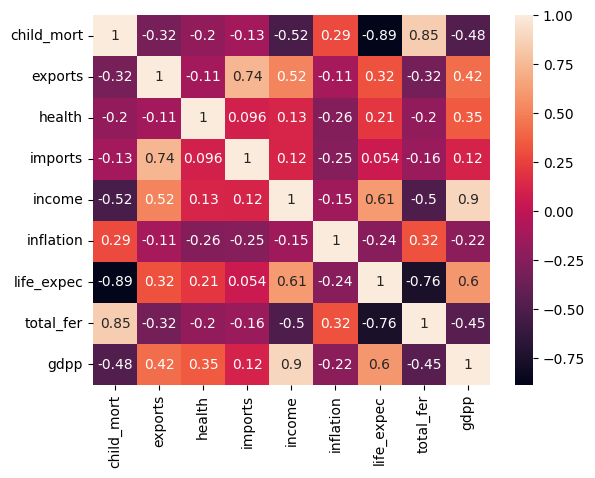

In [196]:
sns.heatmap(pd.DataFrame(X_norm, columns=X.columns).corr(), annot=True);

**Задание 7.4**

Теперь понизим размерность данных — возьмём для этого метод главных компонент (PCA) как самый простой и популярный.

Найдите минимальное число компонент, которые суммарно могут объяснить как минимум 90 % разброса данных.

In [201]:
X_std  = (X_norm - X_norm.mean()) / (X_norm.std())
pca = PCA(n_components=0.9)

principalComponents = pca.fit_transform(X_std)
principalComponents.shape[1]

5

**Задание 7.5**

Используйте главные компоненты, выделенные в предыдущем задании.

Какую долю дисперсии объясняет первая главная компонента? Ответ округлите до двух знаков после точки-разделителя.

In [205]:
pca.explained_variance_ratio_[0].round(2)

0.46

**Задание 7.6**

Как вы помните, при создании компонент с помощью PCA они должны получиться независимыми, то есть мы не должны теперь наблюдать высоких коэффициентов корреляции.

Постройте матрицу корреляций. Сколько значений в ней превышают $0.001$, не считая единичных значений на главной диагонали?

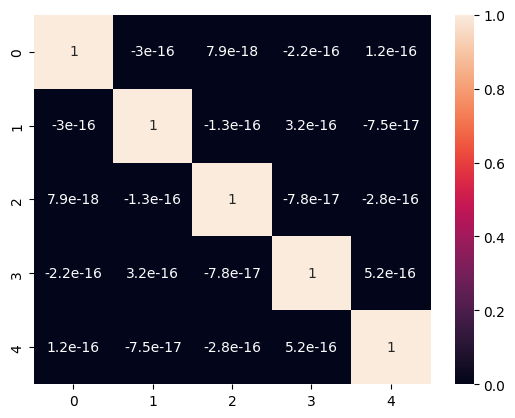

In [207]:
df_pc = pd.DataFrame(principalComponents)
sns.heatmap(df_pc.corr(), annot=True);

**Задание 7.7**

Теперь, когда мы уменьшили размерность данных, можно переходить к кластеризации. Подберите оптимальное количество кластеров с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. Для кластеризации используйте алгоритм k-means++. В качестве значения параметра random_state возьмите число 1.

Судя по полученным результатам, сколько кластеров лучше всего взять?

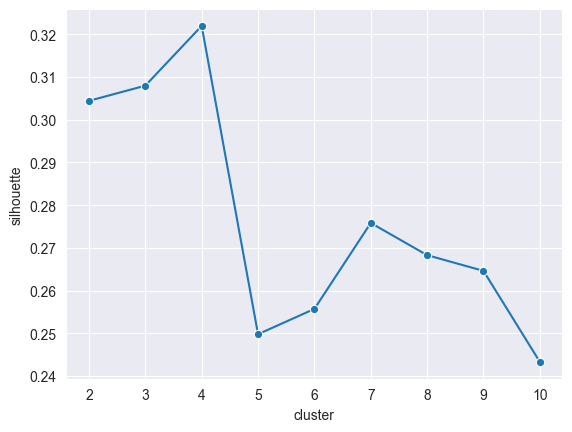

In [209]:
def get_silhouette(cluster_num, X):
    model =  cluster.KMeans(n_clusters=cluster_num, random_state=1).fit(X)
    return metrics.silhouette_score(X, model.predict(X))

s_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 11):
    s_res["silhouette"].append(get_silhouette(cluster_num, df_pc))
    s_res["cluster"].append(cluster_num)
    
sns.set_style("darkgrid")
sns.lineplot(data=pd.DataFrame(s_res), x="cluster", y="silhouette", marker= "o");

**Задание 7.8**

Теперь, когда оптимальное количество кластеров выбрано, реализуйте алгоритм k-means++ с этим параметром. В качестве значения random_state возьмите число 1.

В какой кластер попали страны, у которых самый высокий показатель детской смертности и самый низкий ВВП на душу населения?

In [256]:
km_opt = cluster.KMeans(n_clusters=4, random_state=1).fit(df_pc)
country['clusters'] = km_opt.labels_

<Axes: xlabel='clusters', ylabel='child_mort'>

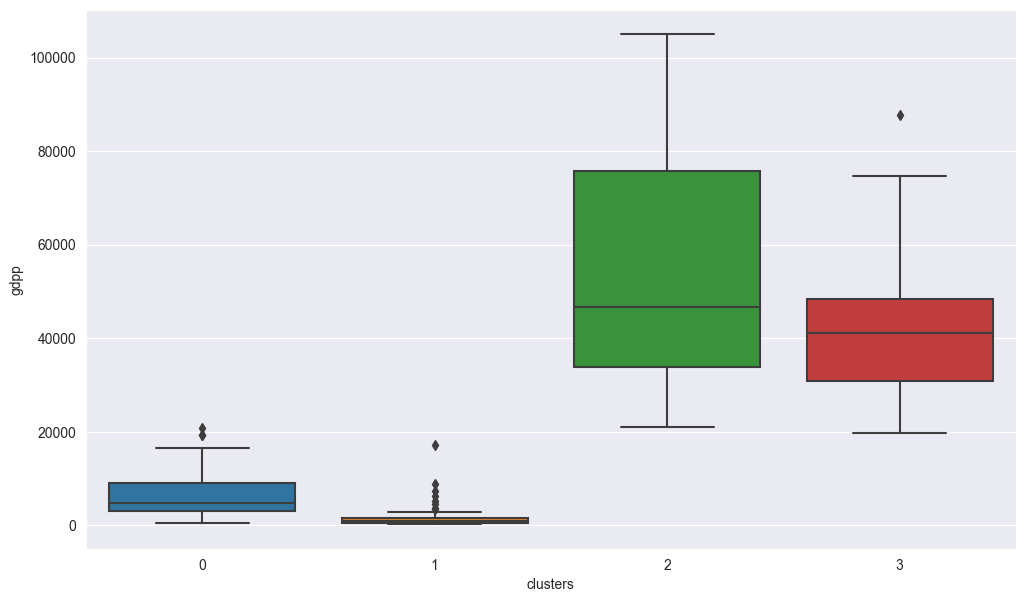

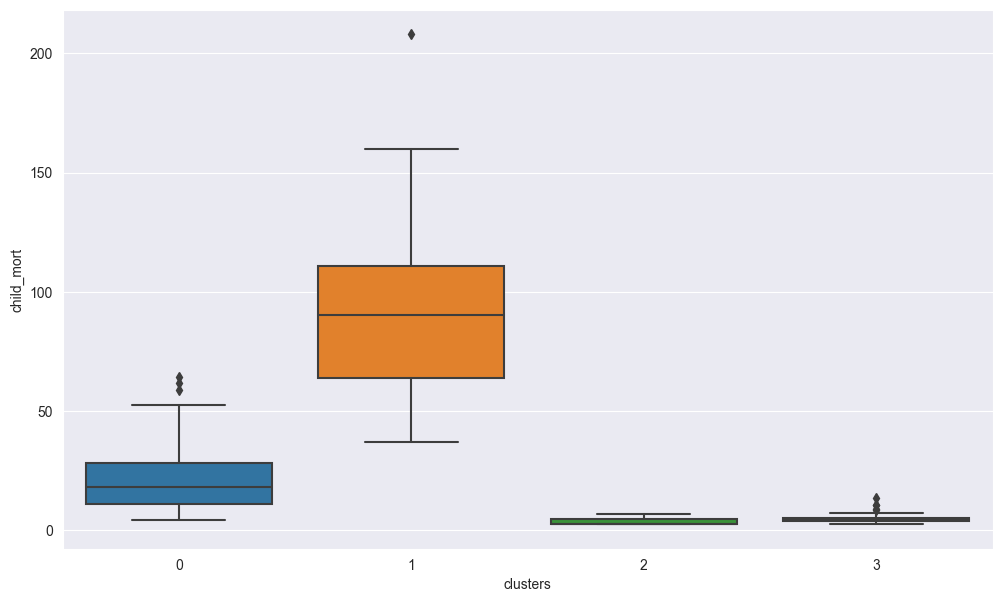

In [257]:
plt.figure(figsize=(12,7))
sns.boxplot(x='clusters', y='gdpp', data=country)
plt.figure(figsize=(12,7))
sns.boxplot(x='clusters', y='child_mort', data=country)

**Задание 7.9**

Итак, мы понимаем, что именно в выбранном нами кластере находятся страны, которые особенно остро нуждаются в финансовой помощи. Однако на все страны у нас не хватит ресурсов, поэтому давайте выберем из выделенного кластера три страны, в которых самая маленькая продолжительность жизни.

In [258]:
country[country['clusters'] == 1].sort_values('life_expec')

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
66,Haiti,208.0,15.30,6.91,64.7,1500,5.450,32.1,3.33,662,1
87,Lesotho,99.7,39.40,11.10,101.0,2380,4.150,46.5,3.30,1170,1
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,1
166,Zambia,83.1,37.00,5.89,30.9,3280,14.000,52.0,5.40,1460,1
94,Malawi,90.5,22.80,6.59,34.9,1030,12.100,53.1,5.31,459,1
137,South Africa,53.7,28.60,8.94,27.4,12000,6.350,54.3,2.59,7280,1
106,Mozambique,101.0,31.50,5.21,46.2,918,7.640,54.5,5.56,419,1
132,Sierra Leone,160.0,16.80,13.10,34.5,1220,17.200,55.0,5.20,399,1
64,Guinea-Bissau,114.0,14.90,8.50,35.2,1390,2.970,55.6,5.05,547,1
0,Afghanistan,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,1
